This IPython Notebook handles the training and evaluation of a neural net that produces a heatmap of edge likelihood from an unsaturated image

In [1]:
# Handle imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import embed
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.nn.parameter import Parameter


In [2]:
class ImageGenerator():
    def __init__(self, shape: tuple, batchSize: int):
        self.shape = np.array(shape)
        self.batchSize = batchSize

    def generate_batch(self):
        imageBatch = np.zeros([self.batchSize, self.shape[0], self.shape[1]])
        edgeBatch = np.zeros([self.batchSize, self.shape[0], self.shape[1]])

        for i in range(self.batchSize):
            image, edgeImg = self.generate_image()
            imageBatch[i] = image
            edgeBatch[i] = edgeImg

    def generate_image(self) -> np.ndarray:
        shapeBGR = (self.shape[1], self.shape[0], 3)
        imageBGR = np.zeros(shapeBGR, 'uint8')

        # make array of corner indeces
        corners = np.array([[0,0],[0,1],[1,1],[1,0],[0,0],[0,1],[1,1],[1,0]]) * (self.shape - 1)
        b = np.random.randint(0,4)  # random starting corner
        c = np.random.randint(1,4) + b  # pick 1-3 total corners

        # pick random edge points for edge line
        rands = np.random.random(2)
        dir0 = corners[b] - corners[b-1]
        dir1 = corners[c] - corners[c-1]
        point0 = dir0*rands[0] + corners[b-1]
        point1 = dir1*rands[1] + corners[c-1]

        # construct polygon
        polygon = corners[b:c]
        polygon = np.concatenate(([point0], polygon, [point1]), axis=0)
        polygon = polygon.astype(np.int32)
        polygon = np.expand_dims(polygon, 1)
        cv2.fillPoly(imageBGR, [polygon], (255,255,255), lineType=cv2.LINE_AA)

        image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

        edgeImageBGR = np.zeros(shapeBGR, 'uint8')
        edge = [0, -1]
        cv2.polylines(edgeImageBGR, [polygon[edge]], False, (255,255,255), lineType=cv2.LINE_AA)

        edgeImage = cv2.cvtColor(edgeImageBGR, cv2.COLOR_BGR2GRAY)

        return image, edgeImage



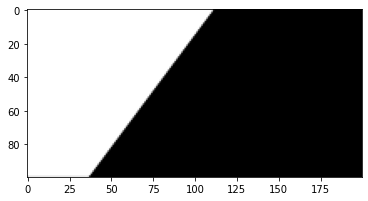

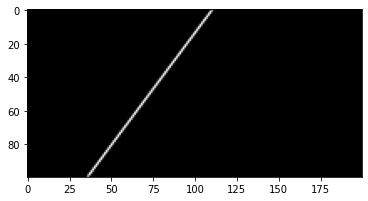

(100, 200)


In [8]:
generator = ImageGenerator((200, 100), 1)
img, edgeImg = generator.generate_image()

def imshow(image: np.ndarray):
    if image.ndim == 2:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    elif image.ndim == 3:
        plt.imshow(image[:,:,::-1])
    else:
        raise(ValueError)
    plt.show()

imshow(img)
imshow(edgeImg)

print(img.shape)

In [4]:
# Test for the random polygon algorithm
a = np.array([[0,0],[0,2],[1,2],[1,0],[0,0],[0,2],[1,2],[1,0]])
b = np.random.randint(0,4)
c = np.random.randint(1,4) + b
print(b, c)
rands = np.random.random(2)
point0 = (a[b] - a[b-1])*rands[0] + a[b-1]
point1 = (a[c] - a[c-1])*rands[1] + a[c-1]

poly = a[b:c]
poly = np.concatenate(([point0], poly, [point1]), axis=0)

print(poly)

1 2
[[0.         1.42055172]
 [0.         2.        ]
 [0.09723064 2.        ]]


In [5]:
class UNet(nn.Module):
  """ Implements the UNet architecture for cancer detection """
  def __init__(self):
    super(UNet, self).__init__()
    self.conv1 = nn.Conv2d(1,64,kernel_size = (3, 3), padding = (1,1))
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(64,64,kernel_size = (3, 3), padding = (1,1))
    self.relu4 = nn.ReLU()
    self.max5 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2, padding = (0,0))
    
    self.conv6 = nn.Conv2d(64,128,kernel_size = (3, 3), padding = (1,1))
    self.relu7 = nn.ReLU()
    self.conv8 = nn.Conv2d(128,128,kernel_size = (3, 3), padding = (1,1))
    self.relu9 = nn.ReLU()
    self.max10 = nn.MaxPool2d(kernel_size = (2, 2), padding = (0,0))
    
    self.conv11 = nn.Conv2d(128,256,kernel_size = (3, 3), padding = (1,1))
    self.relu12 = nn.ReLU()
    self.conv13 = nn.Conv2d(256,256,kernel_size = (3, 3), padding = (1,1))
    self.relu14 = nn.ReLU()
    self.max15 = nn.MaxPool2d(kernel_size = (2, 2), padding = (0,0))
    
    self.conv16 = nn.Conv2d(256,512,kernel_size = (3, 3), padding = (1,1))
    self.relu17 = nn.ReLU()
    self.conv18 = nn.Conv2d(512,512,kernel_size = (3, 3), padding = (1,1))
    self.relu19 = nn.ReLU()
    self.max20 = nn.MaxPool2d(kernel_size = (2, 2), padding = (0,0))
    
    self.conv21 = nn.Conv2d(512,1024,kernel_size = (3, 3), padding = (1,1))
    self.relu22 = nn.ReLU()
    self.conv23 = nn.Conv2d(1024,1024,kernel_size = (3, 3), padding = (1,1))
    self.relu24 = nn.ReLU()
    self.upcon25 = nn.ConvTranspose2d(1024, 512, kernel_size = (2,2), padding = 0, stride=2)
    
    self.conv26 = nn.Conv2d(1024,512,kernel_size = (3, 3), padding = (1,1))
    self.relu27 = nn.ReLU()
    self.conv28 = nn.Conv2d(512,512,kernel_size = (3, 3), padding = (1,1))
    self.relu29 = nn.ReLU()
    self.upcon30 = nn.ConvTranspose2d(512, 256, kernel_size = (2,2), padding = 0, stride=2)
    
    self.conv31 = nn.Conv2d(512,256,kernel_size = (3, 3), padding = (1,1))
    self.relu32 = nn.ReLU()
    self.conv33 = nn.Conv2d(256,256,kernel_size = (3, 3), padding = (1,1))
    self.relu34 = nn.ReLU()
    self.upcon35 = nn.ConvTranspose2d(256, 128, kernel_size = (2,2), padding = 0, stride=2)
    
    self.conv36 = nn.Conv2d(256,128,kernel_size = (3, 3), padding = (1,1))
    self.relu37 = nn.ReLU()
    self.conv38 = nn.Conv2d(128,128,kernel_size = (3, 3), padding = (1,1))
    self.relu39 = nn.ReLU()
    self.upcon40 = nn.ConvTranspose2d(128, 64, kernel_size = (2,2), padding = 0, stride=2)
    
    self.conv41 = nn.Conv2d(128,64,kernel_size = (3, 3), padding = (1,1))
    self.relu42 = nn.ReLU()
    self.conv43 = nn.Conv2d(64,64,kernel_size = (3, 3), padding = (1,1))
    self.relu44 = nn.ReLU()
    self.conv45 = nn.Conv2d(64,2,kernel_size = 1, padding = 0)


  def forward(self, input):
    o1 = self.conv1(input)
    o2 = self.relu2(o1)
    o3 = self.conv3(o2)
    o4 = self.relu4(o3)
    o5 = self.max5(o4)
    
    o6 = self.conv6(o5)
    o7 = self.relu7(o6)
    o8 = self.conv8(o7)
    o9 = self.relu9(o8)
    o10 = self.max10(o9)
    
    o11 = self.conv11(o10)
    o12 = self.relu12(o11)
    o13 = self.conv13(o12)
    o14 = self.relu14(o13)
    o15 = self.max15(o14)
    
    o16 = self.conv16(o15)
    o17 = self.relu17(o16)
    o18 = self.conv18(o17)
    o19 = self.relu19(o18)
    o20 = self.max20(o19)
    
    o21 = self.conv21(o20)
    o22 = self.relu22(o21)
    o23 = self.conv23(o22)
    o24 = self.relu24(o23)
    o25 = self.upcon25(o24)

    in25 = torch.cat((o25, o19), 1)
    
    o26 = self.conv26(in25)
    o27 = self.relu27(o26)
    o28 = self.conv28(o27)
    o29 = self.relu29(o28)
    o30 = self.upcon30(o29)

    in30 = torch.cat((o30, o14), 1)
    
    o31 = self.conv31(in30)
    o32 = self.relu32(o31)
    o33 = self.conv33(o32)
    o34 = self.relu34(o33)
    o35 = self.upcon35(o34)

    in35 = torch.cat((o35, o9), 1)
    
    o36 = self.conv36(in35)
    o37 = self.relu37(o36)
    o38 = self.conv38(o37)
    o39 = self.relu39(o38)
    o40 = self.upcon40(o39)

    in40 = torch.cat((o40, o4), 1)
    
    o41 = self.conv41(in40)
    o42 = self.relu42(o41)
    o43 = self.conv43(o42)
    o44 = self.relu44(o43)
    o45 = self.conv45(o44)

    # print(o44.shape)
    # print(o45.shape)
    # print(in35.shape)

    
    
    return o45  #Copy Squeeze stuff?

In [6]:
generator = ImageGenerator((200, 100), 1)

model = UNet()
model.cuda()
objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 20000

for epoch in tqdm(range(epochs)):
    # Get a batch of data
    y_truth = 0
    x = 0

    optimizer.zero_grad()
    y_hat = model(x)

    loss = objective(y_hat, y_truth)

    loss.backward()

    optimizer.step()
    

  0%|          | 0/20000 [00:00<?, ?it/s]


TypeError: conv2d() received an invalid combination of arguments - got (int, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
